# cNMF analysis for TF full dataset
## choosing K
## Identifying different programs for cardiomyocyte development

* Paper: https://elifesciences.org/articles/43803
* Tutorial: https://github.com/dylkot/cNMF/blob/master/Tutorials/analyze_pbmc_example_data.ipynb

In [1]:
#!/usr/bin/env python3
import os
import re
import sys
print(sys.executable)
print(sys.path)
print(sys.version)

import collections
import argparse
#import tables
import itertools
import matplotlib
import glob
import math
%matplotlib inline

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scanpy as sc 
import scanpy.external as sce
from cnmf import cNMF


from scipy.stats import hypergeom

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

from sklearn.metrics.pairwise import cosine_similarity


from collections import defaultdict
from scipy import sparse, io


import scipy.cluster.hierarchy as sch
#from matplotlib_venn import venn2, venn2_circles
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pickle
import seaborn as sns

import gseapy as gp
from gseapy import Msigdb
import requests

from matplotlib.colors import LinearSegmentedColormap

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('matplotlib', matplotlib.__version__)
print('scanpy', sc.__version__)


/home2/s438217/.conda/envs/new_scanpy/bin/python3.10
['/home2/s438217/.conda/envs/new_scanpy/lib/python310.zip', '/home2/s438217/.conda/envs/new_scanpy/lib/python3.10', '/home2/s438217/.conda/envs/new_scanpy/lib/python3.10/lib-dynload', '', '/home2/s438217/.local/lib/python3.10/site-packages', '/home2/s438217/.conda/envs/new_scanpy/lib/python3.10/site-packages']
3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy 2.0.2
pandas 2.2.3
scipy 1.14.1
matplotlib 3.9.2
scanpy 1.10.3


In [2]:
print('cnmf', sc.__version__)

cnmf 1.10.3


# evaluating different K's 
### details of the run 100 iterations
### highly variable genes - 2000
### K = [5,6,7,8,9,10,11,12,13,14,15,17,19,21,23,25,27,30,35,40,45,50,55,60,70,80,90,100]

## loading the files

In [3]:
output_directory = '/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'tf_perturb'
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)
K_values = [5,6,7,8,9,10,11,12,13,14,15,17,19,21,23,25,27,30,35,40,45,50,55,60,70,80,90,100,150,200,250,500]
density_threshold = 0.1



In [4]:
# New function from version 1.4
def load_results(self, K, density_threshold, n_top_genes=300):
        """
        Loads normalized usages and gene_spectra_scores for a given choice of K and 
        local_density_threshold for the cNMF run. Additionally returns a DataFrame of
        the top genes linked to each program with the number of genes indicated by the
        `n_top_genes` parameter

        Returns
        usage - cNMF usages (cells X K) normalized to sum to 1
        spectra - Z-score regressed coeffecients for each program (K x genes) with higher values cooresponding
                    to better marker genes
        top_genes - ranked list of marker genes per GEP (n_top_genes X K)
        """
        scorefn = self.paths['gene_spectra_score__txt'] % (K, str(density_threshold).replace('.', '_'))
        tpmfn = self.paths['gene_spectra_tpm__txt'] % (K, str(density_threshold).replace('.', '_'))
        usagefn = self.paths['consensus_usages__txt'] % (K, str(density_threshold).replace('.', '_'))
        spectra_scores = pd.read_csv(scorefn, sep='\t', index_col=0).T
        spectra_tpm = pd.read_csv(tpmfn, sep='\t', index_col=0).T

        usage = pd.read_csv(usagefn, sep='\t', index_col=0)
        usage = usage.div(usage.sum(axis=1), axis=0)

        try:
            usage.columns = [int(x) for x in usage.columns]
        except:
            print('Usage matrix columns include non integer values')

        top_genes = []
        for gep in spectra_scores.columns:
            top_genes.append(list(spectra_scores.sort_values(by=gep, ascending=False).index[:n_top_genes]))

        top_genes = pd.DataFrame(top_genes, index=spectra_scores.columns).T
        return(usage, spectra_scores, spectra_tpm, top_genes)

In [5]:
cNMF_output_dict_all_Ks = {}

# Iterate over each K value
for K in K_values:
    usage_norm, gep_scores, gep_tpm, topgenes = load_results(cnmf_obj, K=K, density_threshold=density_threshold)
    
    # Rename the columns of usage_norm
    usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]
    
    # Store the results in the dictionary with dynamic keys
    cNMF_output_dict_all_Ks[f'usage_norm_k_{K}'] = usage_norm
    cNMF_output_dict_all_Ks[f'gep_scores_k_{K}'] = gep_scores
    cNMF_output_dict_all_Ks[f'gep_tpm_k_{K}'] = gep_tpm
    cNMF_output_dict_all_Ks[f'topgenes_k_{K}'] = topgenes


In [6]:
cNMF_output_dict_all_Ks['usage_norm_k_250']

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,...,Usage_241,Usage_242,Usage_243,Usage_244,Usage_245,Usage_246,Usage_247,Usage_248,Usage_249,Usage_250
AAACCTGAGAAACCGC-1,0.000000,0.120087,0.078816,0.147767,0.074206,0.217646,0.029817,0.030291,0.046241,0.062887,...,0.000042,0.000000,0.000000,0.000036,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000
AAACCTGAGAAACGCC-19,0.252624,0.281591,0.045061,0.000000,0.084316,0.049748,0.031505,0.000000,0.021361,0.048137,...,0.000032,0.000000,0.000046,0.001199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000042
AAACCTGAGAAAGTGG-17,0.494589,0.010023,0.023547,0.121563,0.009107,0.052717,0.000000,0.000000,0.019175,0.017386,...,0.000000,0.000000,0.000000,0.000007,0.000016,0.000000,0.000000,0.000000,0.000000,0.000000
AAACCTGAGAAAGTGG-24,0.000000,0.237523,0.049046,0.042831,0.082949,0.162498,0.138364,0.013425,0.129322,0.000000,...,0.000002,0.000000,0.000000,0.000000,0.000974,0.000000,0.000002,0.000000,0.000016,0.000005
AAACCTGAGAACAATC-15,0.000000,0.085267,0.025441,0.067713,0.000000,0.201498,0.000000,0.013192,0.327703,0.005760,...,0.000000,0.000196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000141,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCTTTACGT-15,0.392996,0.018359,0.019858,0.131242,0.000000,0.000000,0.085829,0.000000,0.000000,0.092536,...,0.000000,0.000068,0.000000,0.000030,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000
TTTGTCATCTTTAGGG-23,0.351629,0.067806,0.000000,0.061374,0.029596,0.000000,0.009566,0.000000,0.072834,0.038095,...,0.000000,0.000000,0.000329,0.000147,0.000000,0.000000,0.000046,0.000000,0.000000,0.000000
TTTGTCATCTTTAGGG-28,0.000000,0.000000,0.163478,0.000000,0.061440,0.038850,0.130737,0.020776,0.070936,0.059375,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000359,0.000000
TTTGTCATCTTTAGTC-24,0.004932,0.000000,0.000000,0.000000,0.000000,0.320765,0.000000,0.007678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000


### Assessing perturbation sensitivity by comparing mean usage score of targeting cells  with non-targeting cells

In [5]:


def compare_scores(usage_norm_k, cell_gRNA):
    """
    Compare scores between non-targeting rows and rows where other genes are active (value 1),
    as well as comparing non-targeting rows with themselves, and calculate log2 fold change.
    
    Parameters:
    usage_norm_k (pd.DataFrame): DataFrame containing score columns.
    cell_gRNA (pd.DataFrame): DataFrame containing binary indicators (0 or 1).
    
    Returns:
    pd.DataFrame: A DataFrame containing the results of the Mann-Whitney U tests and log2 fold changes.
    """
    # Create a list to store results
    results = []

    # Get the indices of rows where 'non-targeting' is 1 in cell_gRNA
    non_targeting_rows = cell_gRNA.index[cell_gRNA['non-targeting'] == 1]

    # Loop over all score columns in usage_norm_k
    for score_col in usage_norm_k.columns:
        # Compare non-targeting with itself
        scores_non_targeting_self = usage_norm_k.loc[non_targeting_rows, score_col]
        stat_self, p_value_self = mannwhitneyu(scores_non_targeting_self, scores_non_targeting_self, alternative='two-sided')
        
        # Store self-comparison results
        results.append({
            'Gene': 'non-targeting (self)',
            'Score Column': score_col,
            'Statistic': stat_self,
            'p-value': p_value_self,
            'Log2 Fold Change': np.nan  # No change when comparing with itself
        })

        # Loop over each gene column in cell_gRNA
        for gene_col in cell_gRNA.columns:
            if gene_col != 'non-targeting':
                # Get indices of rows where the current gene column has value 1
                comparison_rows = cell_gRNA.index[cell_gRNA[gene_col] == 1]

                # If there are no rows in the comparison group, skip to the next gene column
                if len(comparison_rows) == 0:
                    continue

                # Extract scores for the two groups from usage_norm_k
                scores_comparison = usage_norm_k.loc[comparison_rows, score_col]

                # Perform Mann-Whitney U test
                stat, p_value = mannwhitneyu(scores_non_targeting_self, scores_comparison, alternative='two-sided')

                # Calculate log2 fold change
                mean_non_targeting = scores_non_targeting_self.mean()
                mean_comparison = scores_comparison.mean()
                
                # Avoid division by zero; use np.log2(1) for log2FC if mean is zero
                log2fc = np.log2((mean_comparison + 1e-9) / (mean_non_targeting + 1e-9))

                # Store results
                results.append({
                    'Gene': gene_col,
                    'Score Column': score_col,
                    'Statistic': stat,
                    'p-value': p_value,
                    'Log2 Fold Change': log2fc
                })

    # Create a DataFrame from results
    results_df = pd.DataFrame(results)

    # Apply Benjamini-Hochberg correction
    reject, corrected_p_values = multipletests(results_df['p-value'], method='fdr_bh')[:2]

    # Add corrected p-values to the results DataFrame
    results_df['Corrected p-value (BH)'] = corrected_p_values

    return results_df


#### THE ADATA WAS TOO BIG  RAN IT IN CLUSTER
#### THE RESULTING FILES ARE BELOW

## loading the compare score for sig perturbations

In [6]:
import pickle

In [7]:
with open('/project/GCRB/Hon_lab/s438217/cNMF/TF_full/TF_perturb_full/compare_score_pert_all_k_all_targets_clear_gRNA_12_3_24.pkl', 'rb') as file:
    compare_score_pert_all_ks = pickle.load(file)

In [8]:

# Initialize an empty list to store significant results
significant_results = []

# Iter ate through each DataFrame in final_results
for k, df in compare_score_pert_all_ks.items():
    if isinstance(df, pd.DataFrame):
        df["Corrected p-value (BH)"] = df["Corrected p-value (BH)"].round(4)
        # Filter for rows with corrected p-values less than 0.05
        #significant_df = df[df['Corrected p-value (BH)'] < 0.001]
        significant_df = df
        
        # If there are significant results, add them to the list with the key
        if not significant_df.empty:
            significant_df['K'] = k  # Add a column for the key
            significant_results.append(significant_df)

# Concatenate all significant DataFrames into one
if significant_results:
    significant_k = pd.concat(significant_results, ignore_index=True)
else:
    significant_k = pd.DataFrame()  # Empty DataFrame if no significant results'''




### Without any filter

In [9]:
significant_k = significant_k.sort_values(by = "Corrected p-value (BH)")

### Using  OR genes to determine p value for significance
### Determining p value that has less OR genes as hit

In [10]:
OR = significant_k[significant_k["Gene"].str.startswith("OR")]

In [11]:
significant_k =  significant_k[significant_k["Corrected p-value (BH)"]<0.001]

In [12]:
significant_k['Numeric K'] = significant_k['K'].str.extract('(\d+)').astype(int)


In [13]:
significant_k['Numeric K'] = significant_k['K'].str.extract('(\d+)').astype(int)
significant_k = significant_k.sort_values(by='Numeric K')
significant_counts = significant_k.groupby('K').size().reset_index(name='Count')
significant_counts['Numeric K'] = significant_counts['K'].str.extract('(\d+)').astype(int)
significant_counts = significant_counts.sort_values(by='Numeric K')



## unique TF per K- Supplementary figures

In [14]:
# Initialize a set to track seen genes and a result list
seen_genes = set()
result = []

# Iterate through each unique K value
for k in sorted(significant_k['Numeric K'].unique()):
    # Get the unique genes for the current K that haven't been seen yet
    current_genes = significant_k[significant_k['Numeric K'] == k]['Gene'].unique()
    unique_genes_for_k = [gene for gene in current_genes if gene not in seen_genes]
    
    # Count the unique genes
    unique_count = len(unique_genes_for_k)
    
    # Add the count to the result list
    result.append({'Numeric K': k, 'Unique Gene Count': unique_count})
    
    # Update the seen genes set
    seen_genes.update(unique_genes_for_k)

# Convert the result list to a DataFrame
result_df = pd.DataFrame(result)
result_df = result_df.iloc[:31,:]


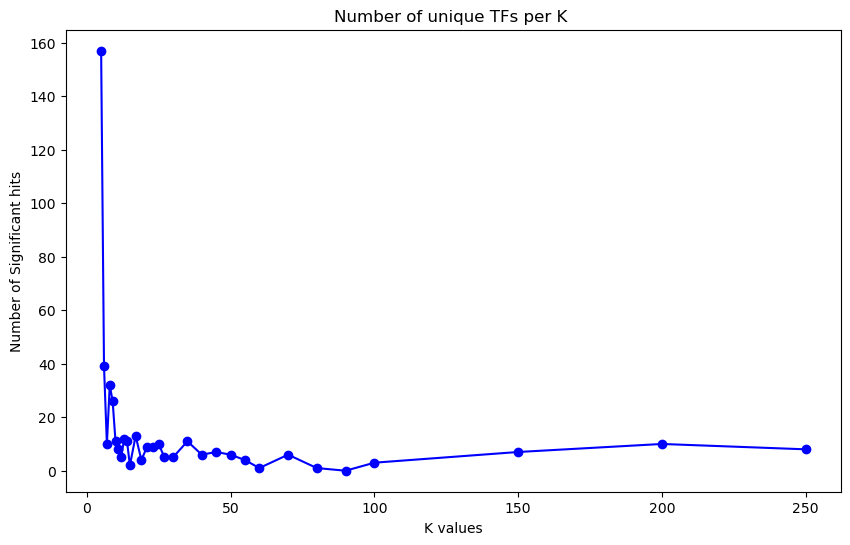

In [15]:

# Prepare data for plotting
Ks = list(result_df["Numeric K"])
unique_counts = list(result_df["Unique Gene Count"])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Ks, unique_counts, marker='o', linestyle='-', color='b')
plt.title('Number of unique TFs per K ')
plt.xlabel('K values')
plt.ylabel('Number of Significant hits')
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/unique_TF_K_250_TF_full.pdf")
#plt.xticks(Ks)  # Ensure all K values are shown on the x-axis
#plt.grid()
#plt.tight_layout()
plt.show()


/tmp/ipykernel_24638/1475401833.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


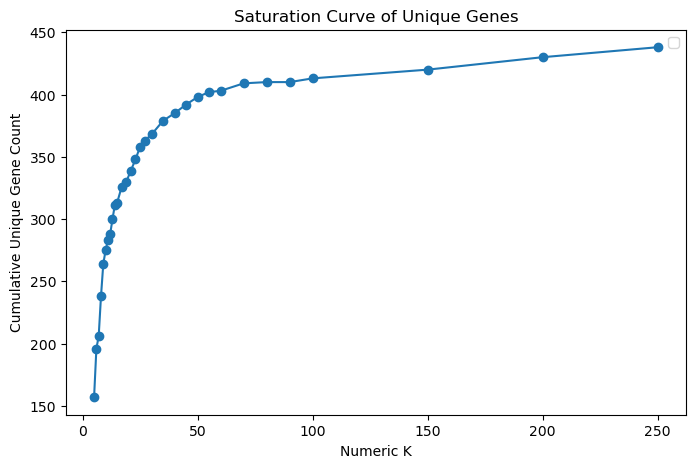

In [16]:


# Compute the cumulative sum of unique gene counts
result_df['Cumulative Unique Gene Count'] = result_df['Unique Gene Count'].cumsum()

# Plot the saturation curve
plt.figure(figsize=(8, 5))
plt.plot(result_df['Numeric K'], result_df['Cumulative Unique Gene Count'], marker='o', linestyle='-')

# Label the axes
plt.xlabel('Numeric K')
plt.ylabel('Cumulative Unique Gene Count')
plt.title('Saturation Curve of Unique Genes')

# Highlight the saturation trend
#plt.axhline(y=result_df['Cumulative Unique Gene Count'].max())
plt.legend()

# Show the plot
plt.show()


## Gene ontology term evaluation
## recovering unique GO terms for every K at seeing where they saturate

### gene by program matrix
### top N=300 Genes

In [19]:

# Assume cNMF_output_dict_all_Ks is already defined and contains your data
top_genes_dict = {}

# Loop through each K value
for K in K_values:
    gep_zscore = cNMF_output_dict_all_Ks[f"gep_scores_k_{K}"]  # Access the DataFrame directly
    top_genes = []
    ngenes = 300
    
    for gep in gep_zscore.columns:
        # Sort and get the top genes
        top_genes.append(list(gep_zscore.sort_values(by=gep, ascending=False).index[:ngenes]))
    
    # Store the result in a dictionary with K as the key
    top_genes_dict[K] = pd.DataFrame(top_genes, index=gep_zscore.columns).T

# Now top_genes_dict contains top genes for each K


### Cosine similarity score to quantify the uniqueness of each program
### Blue is not similar
### red is very similar

In [20]:
Top_genes_300 = top_genes_dict[250]

#Top_genes_300.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/top_300_genes_K_250_per_program_TF_full.csv")

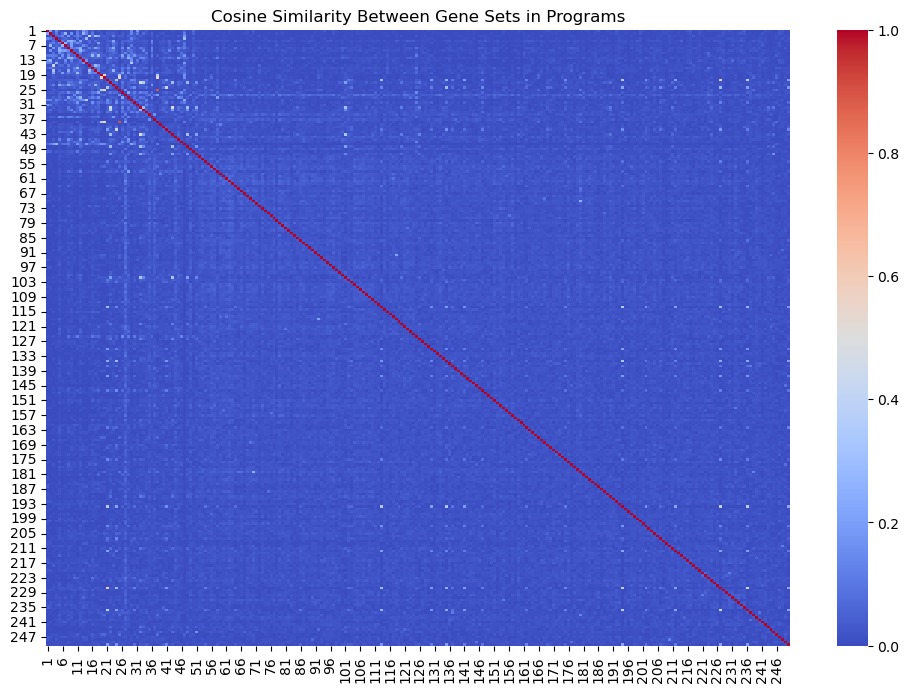

In [24]:



# Assuming 'Top_genes_300' is a DataFrame (300 rows × 250 columns) with gene names

# Step 1: Get a list of all unique genes across all columns
all_genes = list(pd.unique(Top_genes_300.values.ravel()))  # Flatten and get unique genes

# Step 2: Create a binary matrix (rows: unique genes, cols: original columns)
binary_matrix = pd.DataFrame(0, index=all_genes, columns=Top_genes_300.columns)

# Step 3: Fill matrix with 1s where a gene is present in a column
for col in Top_genes_300.columns:
    binary_matrix.loc[Top_genes_300[col].dropna(), col] = 1

# Step 4: Compute cosine similarity between columns
cosine_sim = cosine_similarity(binary_matrix.T)  # Transpose to compare columns

# Step 5: Convert to DataFrame for better visualization
cosine_sim_df = pd.DataFrame(cosine_sim, index=Top_genes_300.columns, columns=Top_genes_300.columns)

# Step 6: Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cosine_sim_df, cmap="coolwarm", annot=False)
plt.title("Cosine Similarity Between Gene Sets in Programs")

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/K_250_top_300_genes_cosine_similarity_heatmap.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()


## Gene ontology file - this was run on cluster and the resulting file used

In [2]:
with open('/project/GCRB/Hon_lab/s438217/cNMF/TF_full/TF_perturb_full/TF_full_GO_all_enriched_results.pkl', 'rb') as file:
    enrichment_results = pickle.load(file)
    


In [3]:
GO_250 = enrichment_results[250]

In [4]:
GO_250 = GO_250[GO_250["Adjusted P-value"]<0.05]

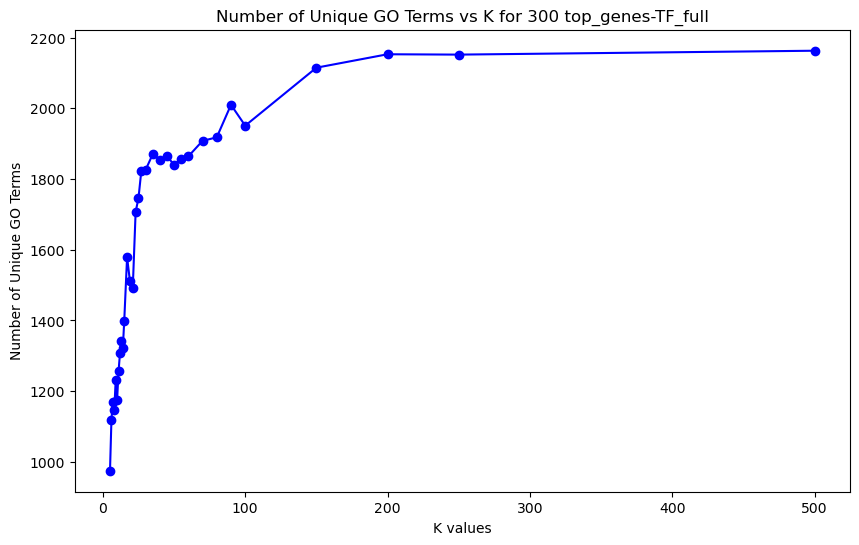

In [32]:

# Assuming you have a dictionary of DataFrames `dfs_dict`
filtered_dict = {}

# Loop through each key-value pair in the original dictionary
for key, df in enrichment_results.items():
    # Check if the adjusted p-value column exists
    if 'Adjusted P-value' in df.columns:
        # Filter rows where the adjusted p-value is less than 0.05
        filtered_df = df[df['Adjusted P-value'] < 0.05]
        
        # Store the filtered DataFrame in the new dictionary
        filtered_dict[key] = filtered_df

# Now filtered_dict contains the filtered DataFrames where adjusted p-value < 0.05

# Initialize a dictionary to hold counts of unique terms for each K
unique_terms_count = {}

K_values = [k for k in K_values if k in filtered_dict]

# Loop through each K value in filtered_results_dict
for K in K_values:
    terms_set = set()  # Use a set to store unique terms for the current K
    
    # Get the filtered results for current K
    enrich_results = filtered_dict[K]
    
 

    terms_set.update(enrich_results['Term'].unique())
    
    # Store the count of unique terms for this K
    unique_terms_count[K] = len(terms_set)

# Now unique_terms_count contains the number of unique GO terms for each K


import matplotlib.pyplot as plt

# Prepare data for plotting
Ks = list(unique_terms_count.keys())
unique_counts = list(unique_terms_count.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Ks, unique_counts, marker='o', linestyle='-', color='b')
plt.title('Number of Unique GO Terms vs K for 300 top_genes-TF_full')
plt.xlabel('K values')
plt.ylabel('Number of Unique GO Terms')
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_TF_full_unique_terms.pdf")
#plt.xticks(Ks)  # Ensure all K values are shown on the x-axis
#plt.grid()
#plt.tight_layout()
plt.show()



In [33]:
K_250 = pd.read_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full/TF_perturb_full/TF_full_sig_perturbations_K_250_FDR_0.001_12_5_24.csv")
#K_250['Program'] = K_250['Score Column'].str.split('_').str[1]

# Convert the new 'program' column to numeric if needed
#K_250['Program'] = pd.to_numeric(K_250['Program'], errors='coerce')
#K_250.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/TF_full_sig_perturbations_K_250_FDR_0.001_12_5_24.csv")

In [34]:
#K_250['BaseGene'] = K_250['Gene'].str.extract(r'^(.*?)-P')
#K_250['BaseGene'] = K_250['Gene'].str.extract(r'^(.*?)-P').fillna(K_250['Gene'])
K_250['BaseGene'] = K_250['Gene'].apply(lambda x: x.split('-P')[0] if '-P' in x else x)


## Gene ontology for K 250

In [35]:
GO_250 = enrichment_results[250]
GO_250['neg_log10_p_value'] = -np.log10(GO_250['Adjusted P-value'])
GO_250 = GO_250[GO_250["Adjusted P-value"]<0.05]
GO_250 = GO_250.sort_values(by = "neg_log10_p_value",ascending=False)

### mean perturbation score for each TF for K =250

In [36]:
import pickle

# Replace 'your_file.pkl' with the path to your .pkl file
with open('/project/GCRB/Hon_lab/s438217/cNMF/TF_full/TF_perturb_full/usage_per_perturbation_k_all_targets_clear_gRNA_12_3_24.pkl', 'rb') as file:
    perturbation_score = pickle.load(file)

# Now 'data' contains the content of the pickle file


## Figure 2 - A

## QC - program count/TF, TF count/program
### No of TFs per program


In [37]:
# Group by 'program' and count unique 'Gene' values for each program number
gene_count_per_program = K_250.groupby('Program')['Gene'].nunique().reset_index()

# Rename the columns for better readability
gene_count_per_program.columns = ['Program', 'Unique Gene Count']



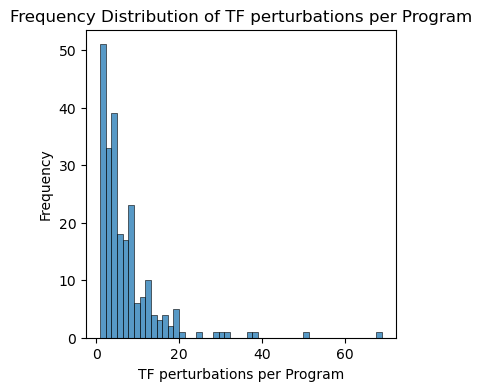

In [38]:
 
plt.figure(figsize=(4, 4))
sns.histplot(gene_count_per_program['Unique Gene Count'], kde=False,  bins=50)

# Add labels and title
plt.xlabel('TF perturbations per Program')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of TF perturbations per Program')
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/Freq_TF_perturbations_per_program_QC.pdf")
plt.show()


In [39]:
gene_count_per_program = gene_count_per_program.sort_values(by = "Unique Gene Count",ascending=False)

In [40]:
gene_count_per_program["Unique Gene Count"].mean()
gene_count_per_program["Unique Gene Count"].median()

np.float64(5.0)

## Number of programs per TF

In [41]:
# Group by 'Gene' and count unique 'Program' values for each gene
program_count_per_gene = K_250.groupby('Gene')['Program'].nunique().reset_index()

# Rename the columns for clarity
program_count_per_gene.columns = ['Gene', 'Program Count']

In [42]:
program_count_per_gene =  program_count_per_gene.sort_values(by = "Program Count",ascending=True)

In [43]:
program_count_per_gene["Program Count"].mean(),program_count_per_gene["Program Count"].median()

(np.float64(6.904564315352697), np.float64(2.0))

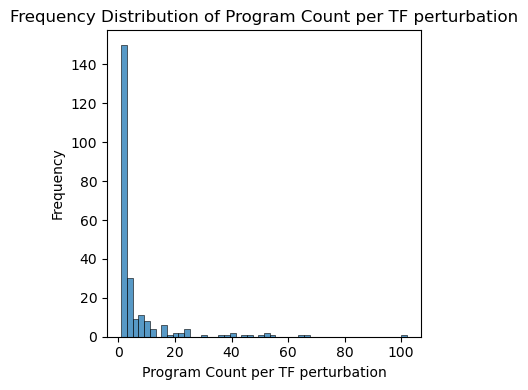

In [44]:
# Plot the histogram with discrete bins and KDE curve
plt.figure(figsize=(4, 4))
sns.histplot(program_count_per_gene['Program Count'], kde=False, bins=50)

# Add labels and title
plt.xlabel('Program Count per TF perturbation')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Program Count per TF perturbation')

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/Freq_program_count_per_TF_QC.pdf")


# Display the plot
plt.tight_layout()
plt.show()

## Gene ontology heatmap

In [62]:
source = [1,28,12,13,67]
program_for_heatmap = GO_250[GO_250["Source"].isin(source)]
program_for_heatmap_sorted = program_for_heatmap.sort_values(by='neg_log10_p_value', ascending=False)
# Step 2: Create a pivot table for the heatmap with all terms
heatmap_data = program_for_heatmap_sorted.pivot(index='Term', columns='Source', values='neg_log10_p_value')

# Ensure column order matches `Source` values
heatmap_data = heatmap_data.reindex(columns=program_for_heatmap['Source'].unique())

# Step 3: Order rows based on column values (you can change the sorting criteria if needed)
heatmap_data = heatmap_data.sort_values(by=heatmap_data.columns.tolist(), ascending=False)




program_for_heatmap_filtered = program_for_heatmap


cap_value = 3  # Cap at -log10(0.001), which corresponds to a p-value of 0.001
program_for_heatmap_filtered['neg_log10_p_value'] = program_for_heatmap_filtered['neg_log10_p_value'].clip(upper=cap_value)

# Step 4: Sort the data by neg_log10_p_value (you can remove the top 5 filtering)
program_for_heatmap_sorted = program_for_heatmap_filtered.sort_values(by='neg_log10_p_value', ascending=False)

# Step 5: Create a pivot table for the heatmap with all terms
heatmap_data = program_for_heatmap_sorted.pivot(index='Term', columns='Source', values='neg_log10_p_value')

# Step 6: Handle NaN values (you can replace NaN with a specific value or leave them as NaN)
# Here, we'll fill NaN values with a specific value and display them as a distinct color
heatmap_data = heatmap_data.fillna(np.nan)  # Use np.nan to keep NaNs as they are

# Ensure column order matches `Source` values
heatmap_data = heatmap_data.reindex(columns=program_for_heatmap['Source'].unique())

heatmap_data = heatmap_data[source]


/tmp/ipykernel_24638/1207902361.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  program_for_heatmap_filtered['neg_log10_p_value'] = program_for_heatmap_filtered['neg_log10_p_value'].clip(upper=cap_value)



## Figure 2 -B

In [63]:
# Step 6: Create a mask for NaN values
mask = np.isnan(heatmap_data)

# Step 7: Replace NaNs with a placeholder value (we'll use zero for clustering)
# This value will be ignored in clustering, but still show as gray in the heatmap.
heatmap_data_for_clustering = heatmap_data.copy()
heatmap_data_for_clustering = heatmap_data_for_clustering.fillna(0)


In [64]:
# Step 1: Filter rows where column "67" has a value other than 0
#rows_to_label = heatmap_data_for_clustering[heatmap_data_for_clustering[67] != 0].index.tolist()

rows_to_label = ['Chemical Synaptic Transmission (GO:0007268)', 'Neuron To Neuron Synapse (GO:0098984)','Cardiac Muscle Cell Development (GO:0055013)','Regulation Of Heart Contraction (GO:0008016)','Embryonic Heart Tube Morphogenesis (GO:0003143)','Adult Heart Development (GO:0007512)',
                'Glucose Metabolic Process (GO:0006006)','Carbohydrate Catabolic Process (GO:0016052)',
                 'Collagen-Containing Extracellular Matrix (GO:0062023)','Collagen Fibril Organization (GO:0030199)']
# Step 2: Get the indices of these rows in the DataFrame
row_indices = [heatmap_data_for_clustering.index.get_loc(row) for row in rows_to_label]


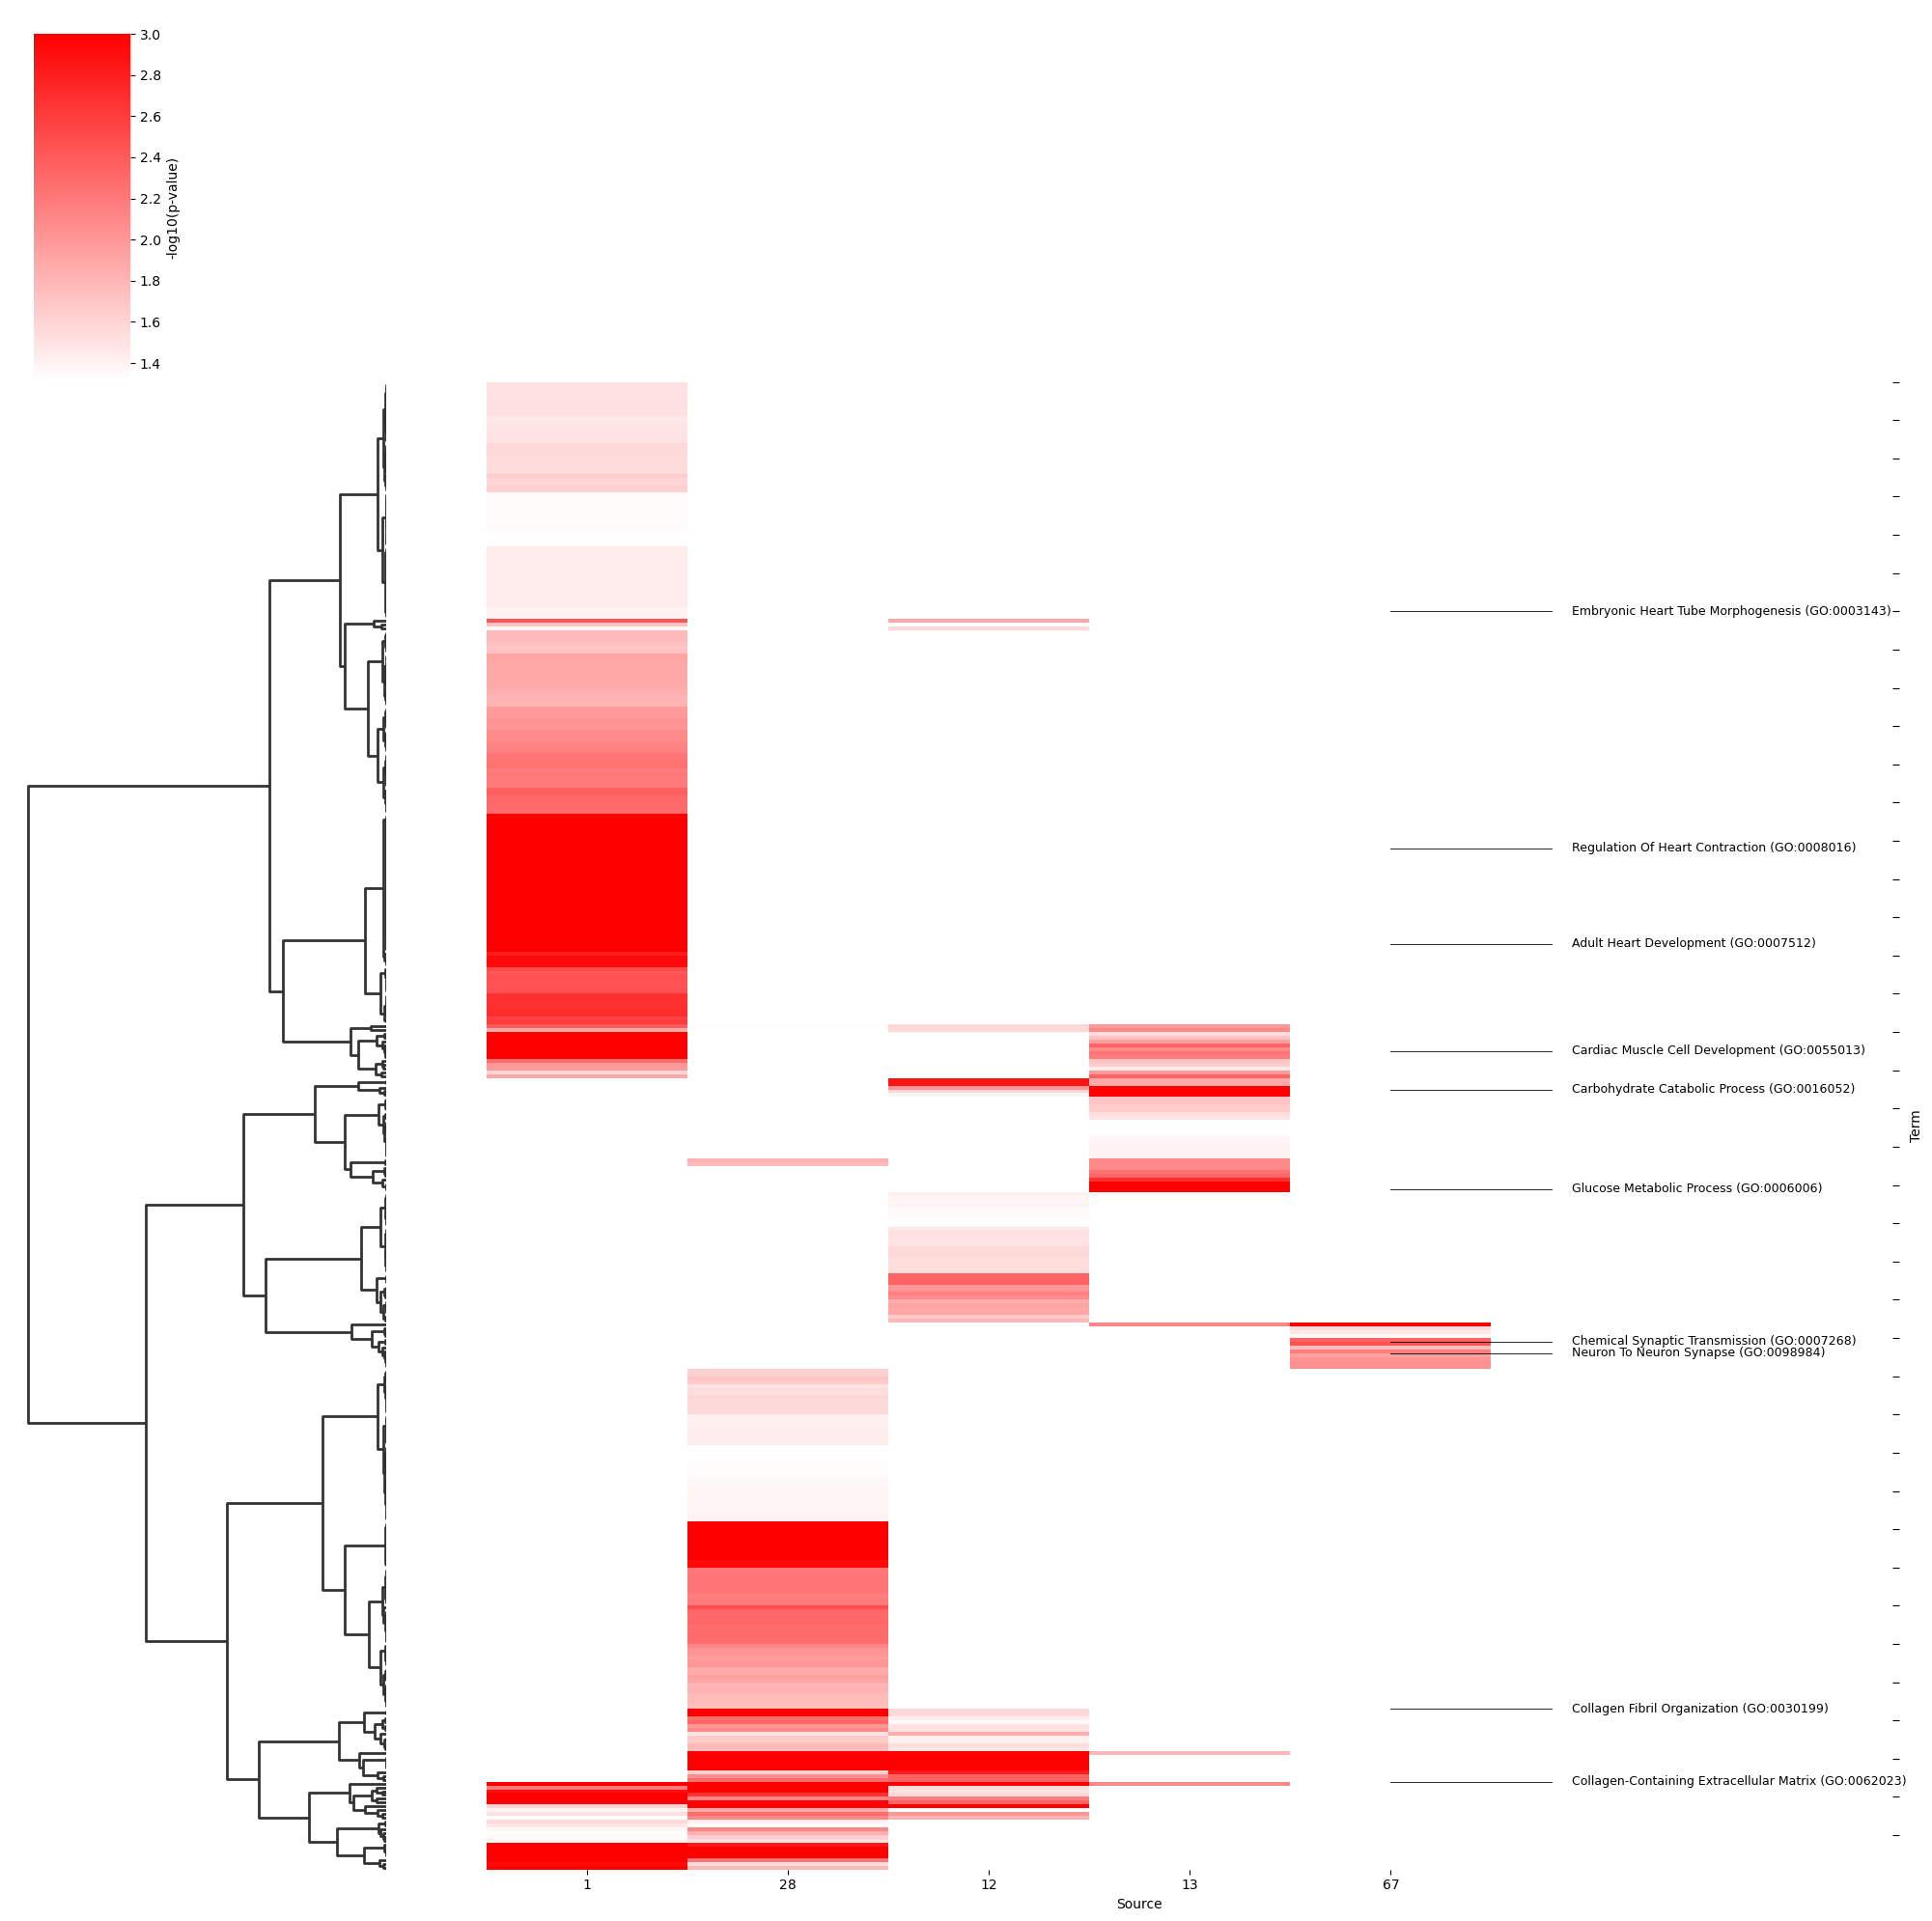

In [67]:


# --- Clean numeric matrix ---
df = heatmap_data_for_clustering.copy()
X = np.asarray(df, dtype=np.float64)
X = np.nan_to_num(X, copy=False)

# --- Safe mask (boolean, same shape) ---
try:
    mask_bool = np.asarray(mask, dtype=bool)
    if mask_bool.shape != X.shape:
        mask_bool = np.zeros_like(X, dtype=bool)
except NameError:
    mask_bool = np.zeros_like(X, dtype=bool)

# --- Row labels to annotate (fallback if your line is commented) ---
try:
    rows_to_label  # if you already defined it, this won't run
except NameError:
    if 67 in df.columns:
        rows_to_label = df.index[df[67] != 0].tolist()
    else:
        rows_to_label = []  # nothing to label if column 67 isn't present

# --- Colormap ---
red_cmap = LinearSegmentedColormap.from_list("RedGradient", ["white", "red"])

# --- PRECOMPUTE LINKAGE (avoids fastcluster) ---
row_linkage = sch.linkage(X, method="ward", metric="euclidean")

# --- Cluster map (method/metric are ignored for rows when row_linkage is given) ---
cluster = sns.clustermap(
    df,
    row_linkage=row_linkage,
    col_cluster=False,
    cmap=red_cmap,
    annot=False,
    cbar_kws={'label': '-log10(p-value)'},
    figsize=(20, 20),
    mask=mask_bool,
    yticklabels=False,
    tree_kws={"linewidths": 2},
)

# --- Reordered labels after clustering ---
reordered_indices = cluster.dendrogram_row.reordered_ind
reordered_labels = df.index.take(reordered_indices)  # Index in new order

# --- Which rows to label (in the reordered list) ---
filtered_rows_to_label = [lbl for lbl in rows_to_label if lbl in reordered_labels]
row_indices = [reordered_labels.get_loc(lbl) for lbl in filtered_rows_to_label]

# --- Draw ticks every 10 rows for orientation ---
ax = cluster.ax_heatmap
num_rows = len(reordered_labels)
tick_positions = np.arange(0, num_rows, 10)
ax.set_yticks(tick_positions)
ax.tick_params(axis='y', direction='out', length=5, color='black')

# --- Add connecting lines + labels outside the heatmap ---
ncols = df.shape[1]
x_start = ncols - 0.5
x_end   = ncols + 0.3  # outside the right edge
ax.set_xlim(-0.5, ncols + 2)  # make room for labels

for idx in row_indices:
    y = idx
    ax.plot([x_start, x_end], [y, y], color='black', lw=0.6, clip_on=False)
    ax.text(x_end + 0.1, y, str(reordered_labels[idx]),
            ha='left', va='center', fontsize=9, color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0), clip_on=False)

plt.show()


## Perturbations associated with a program

## Figure 2 C and 2 I

### Differentiation program

### Mature differentiation program
### Identifying mature cardiac programs and associated perturbations in a systematic way

In [49]:
# List of keywords related to heart
cardiac_keywords = ['Cardiac', 'Heart', 'contraction','Ventricular']

# Function to check if a term contains any of the metabolism-related keywords as a substring
def contains_cardiac(term):
    # Convert term to lowercase and check if any of the keywords appear as substrings
    return any(keyword.lower() in term.lower() for keyword in cardiac_keywords)

# Sort by 'neg_log10_p_value' within each 'Source', descending order
GO_250_sorted = GO_250.sort_values(by=['Source', 'neg_log10_p_value'], ascending=[True, False])

# Get the top 10 rows per 'Source'
top_10_per_source = GO_250_sorted.groupby('Source').head(10)

# Add a new column to indicate if the term is related to metabolism
top_10_per_source['cardiac_related'] = top_10_per_source['Term'].apply(contains_cardiac)
cardiac_programs = top_10_per_source[top_10_per_source["cardiac_related"]==True]

/tmp/ipykernel_24638/3457267384.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_per_source['cardiac_related'] = top_10_per_source['Term'].apply(contains_cardiac)


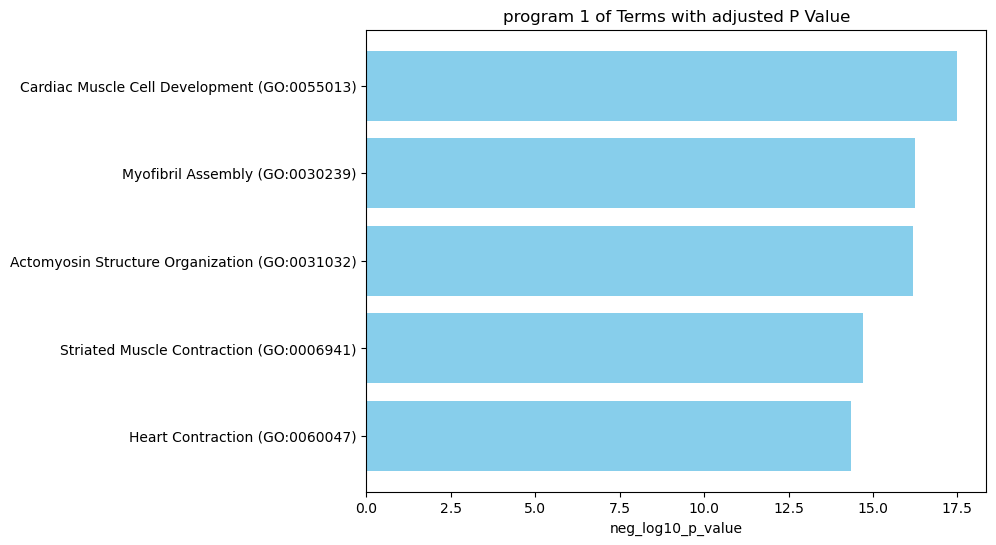

In [50]:
GO_col1 = GO_250[GO_250["Source"]==1]
GO_col1 = GO_col1[GO_col1["Adjusted P-value"]<0.05]
GO_col1 = GO_col1.sort_values(by = "neg_log10_p_value",ascending=False)
GO_col1 = GO_col1.iloc[:5,:]


plt.figure(figsize=(8, 6))
plt.barh(GO_col1['Term'], GO_col1['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 1 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_prog_1_k_250_mature_cardiac_program.pdf")

#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()


## 3 programs were identified with program 1 covering the entire axis of differentiation perturbations that were recovered from smaller K

In [51]:
prog_1_pert = K_250[K_250["Program"]==1]
pd.set_option('display.max_colwidth', None)
prog_1_pert = prog_1_pert.sort_values(by = "Log2 Fold Change")
#prog_1_pert.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program1_TF_full_mature_cardiac_1_10_25.csv")

In [52]:
prog_2_pert = K_250[K_250["Program"]==2]
prog_2_pert = prog_2_pert.sort_values(by = "Log2 Fold Change")

prog_50_pert = K_250[K_250["Program"]==50]
prog_50_pert = prog_2_pert.sort_values(by = "Log2 Fold Change")

### Cluster overlap with known CHD genes from Australian database

In [54]:
Aus_disease = pd.read_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full/chdgene_table_AU.csv")
CHD_list = Aus_disease["Gene"].to_list()
top_genes_250 = top_genes_dict[250]
results = []
for column in top_genes_250.columns:
    # Count the number of overlapping elements
    overlap_count = top_genes_250[column].isin(CHD_list).sum()
    # Get the actual overlapping genes
    overlapped_genes = top_genes_250[column][top_genes_250[column].isin(CHD_list)].tolist()
    # Append the result as a tuple (column name, count, list of overlapping genes)
    results.append((column, overlap_count, overlapped_genes))

# Create a new DataFrame from the results
overlap_df = pd.DataFrame(results, columns=['Column Name', 'Count', 'Overlapped Genes'])
overlap_df = overlap_df.sort_values(by = "Count",ascending=False)


In [55]:
n_CHD =  len(set(CHD_list))# Unique genes in CHD
chd_df = K_250[K_250['Gene'].str.startswith(tuple(CHD_list))]

In [56]:

# Total universe of genes
all_genes = set(top_genes_250.stack().dropna())

# N is the number of unique genes
N = len(all_genes)

# Convert the gene list to a set
gene_set = set(CHD_list)
K = len(gene_set)  # Size of the gene set
threshold = 0.05

# Initialize a list to store results
significant_CHD = []

# Loop through each column
for column in top_genes_250.columns:
    # Drop NaN values and convert to set
    column_genes = set(top_genes_250[column].dropna())
    n = len(column_genes)  # Number of genes in the column
    
    # Calculate the overlap
    overlap_genes = column_genes & gene_set
    k = len(overlap_genes)
    
    # Perform hypergeometric test
    p_value = hypergeom.sf(k - 1, N, K, n)  # Survival function for overlap
    
    # Check for significance
    if p_value < threshold:
        significant_CHD.append({
            "Column": column,
            "Overlap": k,
            "P-value": p_value,
            "Overlapping Genes": list(overlap_genes)  # Add overlapping genes
        })

# Convert significant columns to a DataFrame
significant_CHD_df = pd.DataFrame(significant_CHD)

significant_CHD_df['adj_p_value'] = multipletests(significant_CHD_df['P-value'], method='fdr_bh')[1]
significant_CHD_df = significant_CHD_df[significant_CHD_df["adj_p_value"]<0.05]
significant_CHD_df = significant_CHD_df.sort_values(by = "adj_p_value")



GO_CHD = GO_250[GO_250["Source"].isin(significant_CHD_df["Column"])]
GO_CHD = GO_CHD[GO_CHD["Adjusted P-value"]<0.05]

final_CHD_df = significant_CHD_df[significant_CHD_df["Column"].isin(GO_CHD["Source"])]
final_CHD_df.rename(columns={"Column": "Program"}, inplace=True)

pd.set_option('display.max_colwidth', None)



/tmp/ipykernel_24638/117112775.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_CHD_df.rename(columns={"Column": "Program"}, inplace=True)


## Program 1 and 28 were significantly enriched for CHD genes
##  Perturbations and Gene ontology for program 1 and 28

## Program 1 covered the entire axis of perturbation associated with mature cardiac program

## waterfall plot

In [64]:
#prog_1_pert['BaseGene'] = prog_1_pert['Gene'].str.extract(r'^(.*?)-P')


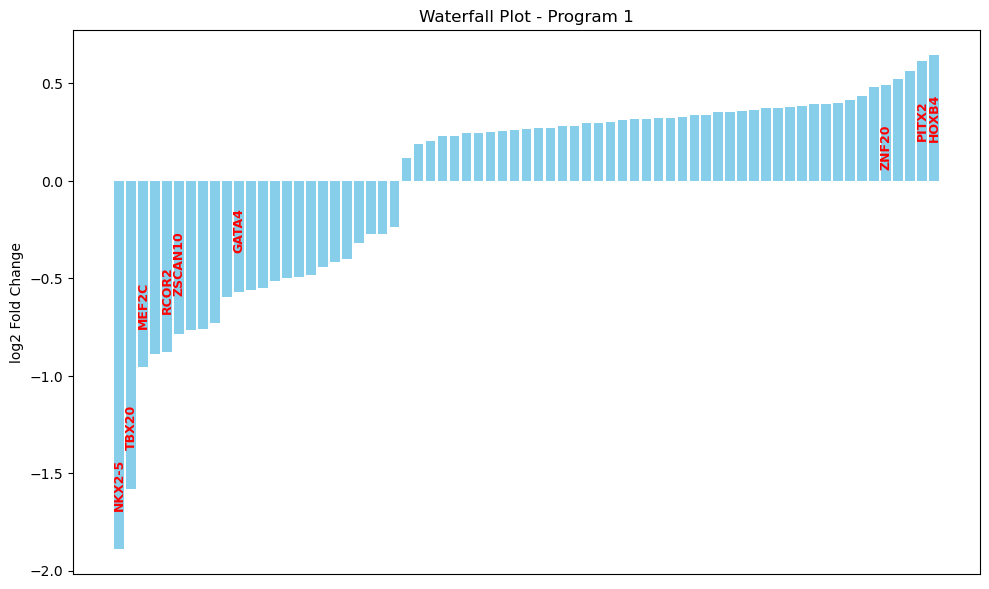

In [62]:
# Sort by log2FC
df = prog_1_pert.sort_values(by='Log2 Fold Change', ascending=True).reset_index(drop=True)

# Genes to label
label_genes = ['NKX2-5','MEF2C', 'PITX2','ZNF20','TBX5','TBX20','RCOR2','ZSCAN10','HOXB4','GATA4']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(df)), df['Log2 Fold Change'], color='skyblue')

# Add gene labels on x-axis if needed (or use index numbers)
#plt.xticks(range(len(df)), df['Gene'], rotation=90, fontsize=8)

plt.xticks([], [])

        

for i, row in df.iterrows():
    if row['BaseGene'] in label_genes:
        y = row['Log2 Fold Change']
        
        # Flip label placement: bottom for positive, top for negative
        y_offset = -0.2 if y > 0 else 0.2
        va = 'top' if y > 0 else 'bottom'
        
        plt.text(i,
                 y + y_offset,
                 row['BaseGene'],
                 ha='center',
                 va=va,
                 rotation=90,
                 fontsize=9, fontweight='bold', color='red')


plt.ylabel('log2 Fold Change')
plt.title('Waterfall Plot - Program 1')
plt.tight_layout()
#plt.savefig('/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_1_water_fall_plot.pdf', dpi=300)

plt.show()

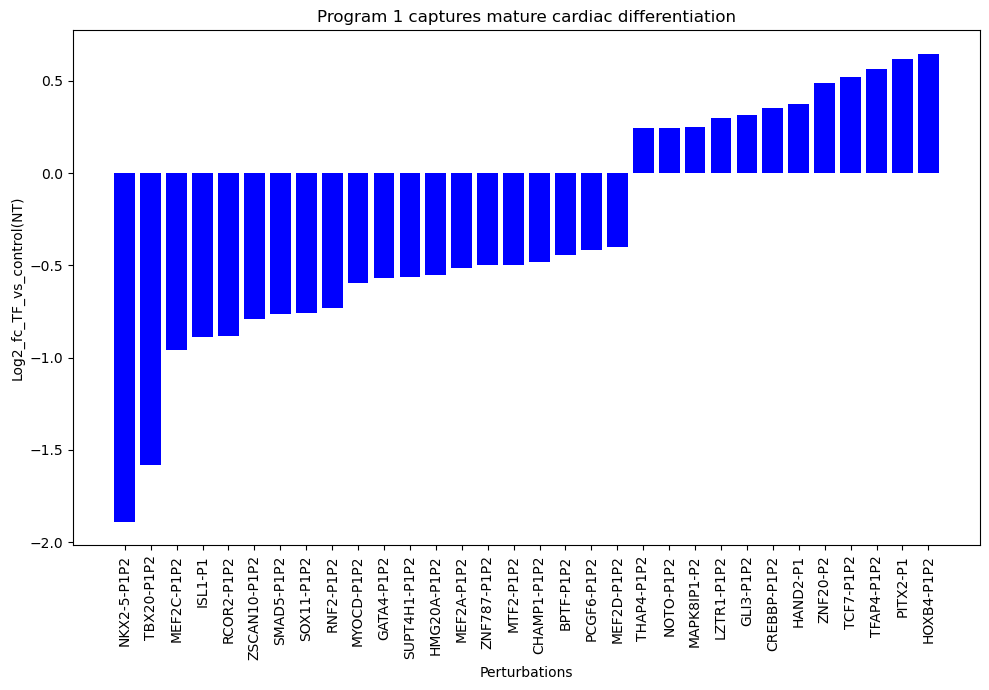

In [51]:
# Top 10 rows
top_10 = prog_1_pert.head(20)

# Middle 10 rows
middle_start = len(prog_1_pert) // 2 - 5  # Start index for middle 10
middle_end = middle_start + 3  # End index for middle 10
middle_10 = prog_1_pert.iloc[middle_start:middle_end]

# Bottom 10 rows
bottom_10 = prog_1_pert.tail(5)

included_genes = prog_1_pert[prog_1_pert["Gene"].isin(chd_df["Gene"])]

# Combine top, middle, bottom rows with included genes
final_selection = pd.concat([top_10, middle_10, bottom_10, included_genes])

# Drop duplicates (in case genes in gene_list are already in top, middle, or bottom)
final_selection = final_selection.drop_duplicates(subset=["Gene"])
final_selection = final_selection.sort_values("Log2 Fold Change")

prog1_plot = pd.concat([top_10,middle_10,bottom_10])

import matplotlib.pyplot as plt

# Assuming sig_67 is your DataFrame
plt.figure(figsize=(10, 7))

# Create a bar plot
plt.bar(final_selection['Gene'], final_selection['Log2 Fold Change'], color='b')

# Add labels and title
plt.xlabel('Perturbations')
plt.ylabel('Log2_fc_TF_vs_control(NT)')
plt.title('Program 1 captures mature cardiac differentiation')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Tight layout for better spacing
plt.tight_layout()

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_1_perturbations_mature_cardiac_program.pdf")
# Show the plot
plt.show()


### Program 1 waterfall plot across all the TFs

In [15]:
import pandas as pd

# Initialize an empty list to store significant results
significant_results = []

# Iter ate through each DataFrame in final_results
for k, df in compare_score_pert_all_ks.items():
    if isinstance(df, pd.DataFrame):
        df["Corrected p-value (BH)"] = df["Corrected p-value (BH)"].round(4)
        # Filter for rows with corrected p-values less than 0.05
        #significant_df = df[df['Corrected p-value (BH)'] < 0.001]
        significant_df = df
        
        # If there are significant results, add them to the list with the key
        if not significant_df.empty:
            significant_df['K'] = k  # Add a column for the key
            significant_results.append(significant_df)

# Concatenate all significant DataFrames into one
if significant_results:
    significant_k = pd.concat(significant_results, ignore_index=True)
else:
    significant_k = pd.DataFrame()  # Empty DataFrame if no significant results'''




In [16]:
significant_k['Numeric K'] = significant_k['K'].str.extract('(\d+)').astype(int)
significant_k = significant_k.sort_values(by='Numeric K')


In [17]:


k_250_all = significant_k[significant_k["Numeric K"]==250]

In [18]:
pd.set_option('display.precision', 10)

import statsmodels.stats.multitest as smm

# Suppose your DataFrame with raw p-values is df
raw_pvals = k_250_all['p-value'].values

# Adjust with Benjamini-Hochberg procedure
_, adj_pvals, _, _ = smm.multipletests(raw_pvals, method='fdr_bh')

# Store adjusted p-values back with full precision
k_250_all['Corrected p-value (BH)'] = adj_pvals

/tmp/ipykernel_34824/2564737902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_250_all['Corrected p-value (BH)'] = adj_pvals


In [19]:
k_250_all

,Gene,Score Column,Statistic,p-value,Log2 Fold Change,Corrected p-value (BH),K,Numeric K
3133190,ZNF92-P1P2,Usage_250,11415884.5,0.5380900426,-0.7194656232,0.9217942948,usage_norm_k_250,250
3133189,ZNF91-P1P2,Usage_250,18973021.5,0.3402200943,0.9908705379,0.8536183694,usage_norm_k_250,250
3133220,ZXDC-P1P2,Usage_250,17354412.0,0.5423224362,-1.2555563450,0.9229819975,usage_norm_k_250,250
3133219,ZXDB-P1P2,Usage_250,22900898.0,0.4188476516,0.0933308141,0.8860385931,usage_norm_k_250,250
3133218,ZXDA-P1P2,Usage_250,14115928.0,0.7066131365,0.5964629337,0.9585902902,usage_norm_k_250,250
...,...,...,...,...,...,...,...,...
2609975,AFF2-P1P2,Usage_1,17320479.5,0.7206671509,0.0265856106,0.9610125585,usage_norm_k_250,250
2609972,ADNP2-P1P2,Usage_1,11343150.5,0.2218424351,-0.0602339676,0.7887412800,usage_norm_k_250,250
2609971,non-targeting (self),Usage_1,879230178.0,1.0000000000,NaN,1.0000000000,usage_norm_k_250,250
3133206,ZSCAN25-P1P2,Usage_250,12675728.0,0.5532250112,-0.8407900654,0.9258429502,usage_norm_k_250,250


In [20]:
k_250_all['Program'] = k_250_all['Score Column'].str.split('_').str[1]

# Convert the new 'program' column to numeric if needed
k_250_all['Program'] = pd.to_numeric(k_250_all['Program'], errors='coerce')
k_250_all['BaseGene'] = k_250_all['Gene'].apply(lambda x: x.split('-P')[0] if '-P' in x else x)

/tmp/ipykernel_34824/4138716347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_250_all['Program'] = k_250_all['Score Column'].str.split('_').str[1]
/tmp/ipykernel_34824/4138716347.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_250_all['Program'] = pd.to_numeric(k_250_all['Program'], errors='coerce')
/tmp/ipykernel_34824/4138716347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [21]:
prog_1_pert_all = k_250_all[k_250_all['Program']==1]

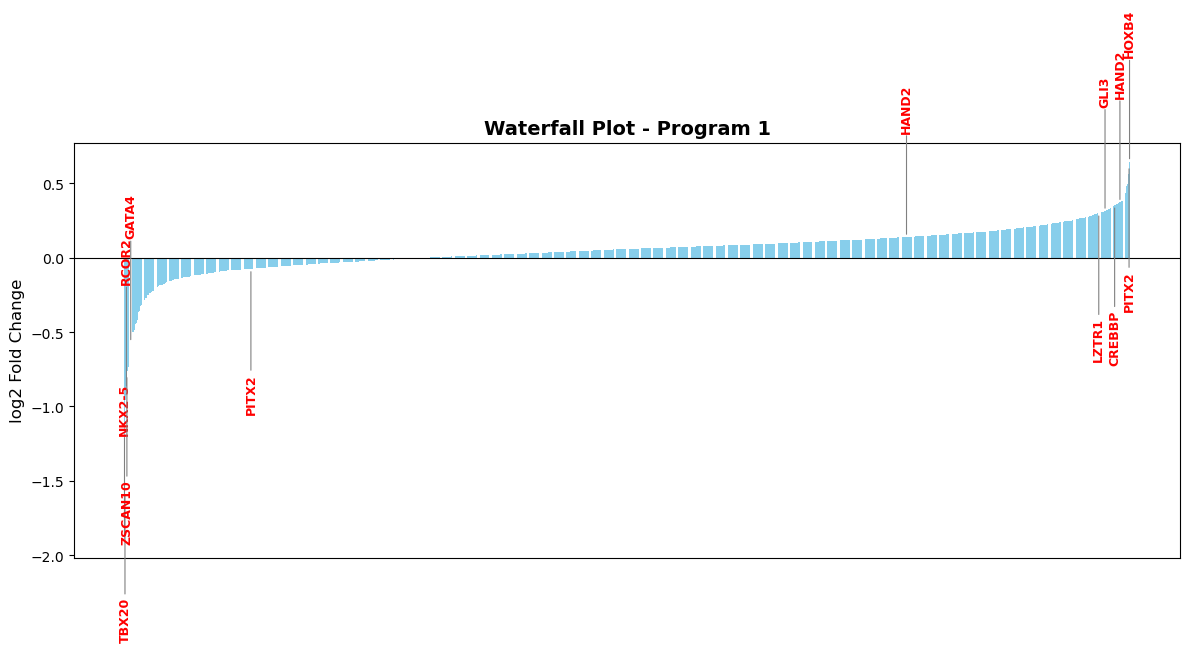

In [22]:


# Sort by log2 Fold Change
df = prog_1_pert_all.sort_values(by='Log2 Fold Change', ascending=True).reset_index(drop=True)

# Genes to label
label_genes = ['NKX2-5', 'TBX20', 'RCOR2', 'ZSCAN10', 'HOXB4', 'PITX2', 'HAND2', 'GLI3', 'GATA4','LZTR1','CREBBP']

# Plot setup
plt.figure(figsize=(12, 7))
bars = plt.bar(range(len(df)), df['Log2 Fold Change'], color='skyblue')

# Hide x-ticks (optional)
plt.xticks([], [])

# Alternate labels top and bottom
direction = 1  # 1 = above, -1 = below

for idx, row in df.iterrows():
    if row['BaseGene'] in label_genes:
        y = row['Log2 Fold Change']
        
        # Placement
        offset = 0.7 * direction  # slightly bigger for space
        va = 'bottom' if direction == 1 else 'top'
        
        # Text
        plt.text(idx,
                 y + offset,
                 row['BaseGene'],
                 ha='center',
                 va=va,
                 rotation=90,
                 fontsize=9,
                 fontweight='bold',
                 color='red')
        
        # Line or arrow
        plt.annotate('',
                     xy=(idx, y),  # start at the bar
                     xytext=(idx, y + offset),  # end at label
                     arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
        
        # Flip direction
        direction *= -1

# Final plot decoration
plt.ylabel('log2 Fold Change', fontsize=12)
plt.title('Waterfall Plot - Program 1', fontsize=14, fontweight='bold')
plt.axhline(0, color='black', linewidth=0.8)  # optional: add a zero-line
plt.tight_layout()
#plt.savefig('/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_1_water_fall_plot.pdf', dpi=300)

# Show plot
plt.show()


### violin plot

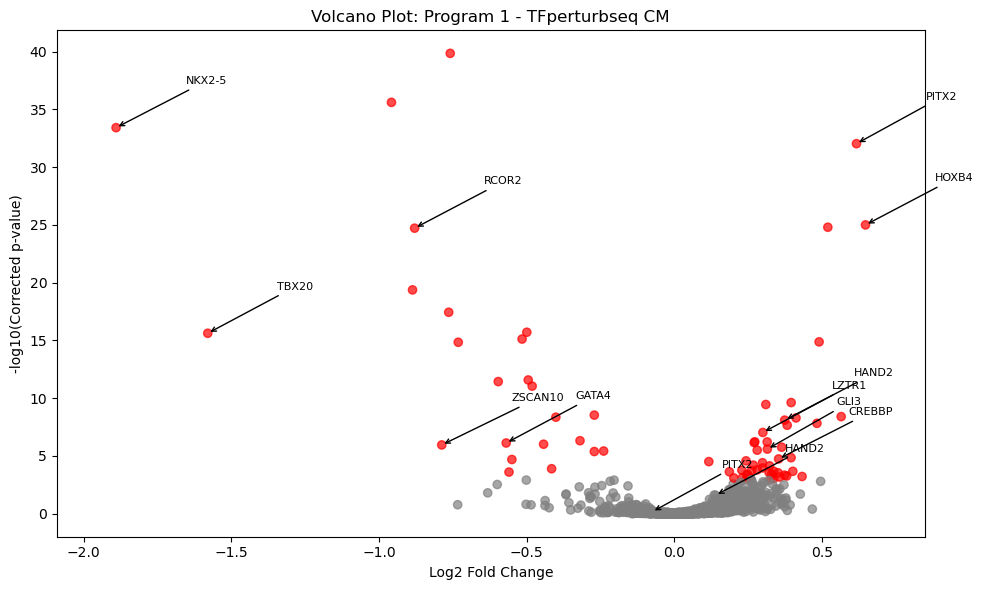

In [34]:
# Drop rows with missing values
df = prog_1_pert_all.dropna(subset=['Log2 Fold Change', 'Corrected p-value (BH)', 'BaseGene']).copy()

# Compute -log10(p-value)
df['-log10(p-value adj)'] = -np.log10(df['Corrected p-value (BH)'])

# Define colors for significant points
colors = np.where(df['Corrected p-value (BH)'] < 0.001, 'red', 'gray')


plt.figure(figsize=(10, 6))
plt.scatter(
    df['Log2 Fold Change'], 
    df['-log10(p-value adj)'], 
    color=colors, 
    alpha=0.7
)


genes_to_label = ['NKX2-5', 'TBX20', 'RCOR2', 'ZSCAN10', 'HOXB4', 'PITX2', 'HAND2', 'GLI3', 'GATA4','LZTR1','CREBBP']

# Label selected genes with arrows and offset text
for _, row in df[df['BaseGene'].isin(genes_to_label)].iterrows():
    plt.annotate(
        row['BaseGene'],
        xy=(row['Log2 Fold Change'], row['-log10(p-value adj)']),
        xytext=(50, 30),  # offset label position in points (x,y)
        textcoords='offset points',
        ha='left',
        va='bottom',
        fontsize=8,
        arrowprops=dict(arrowstyle='->', color='black', lw=1)
    )

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Corrected p-value)')
plt.title('Volcano Plot: Program 1 - TFperturbseq CM')

plt.xlim(df['Log2 Fold Change'].min() - 0.2, df['Log2 Fold Change'].max() + 0.2)

plt.tight_layout()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full/TF_perturb_full/TF_full_CM_program1_violinplot.pdf")
plt.show()
    

### Progrm 28 water fall plot all TFs

In [26]:
prog_28_pert_all = k_250_all[k_250_all['Program']==28]

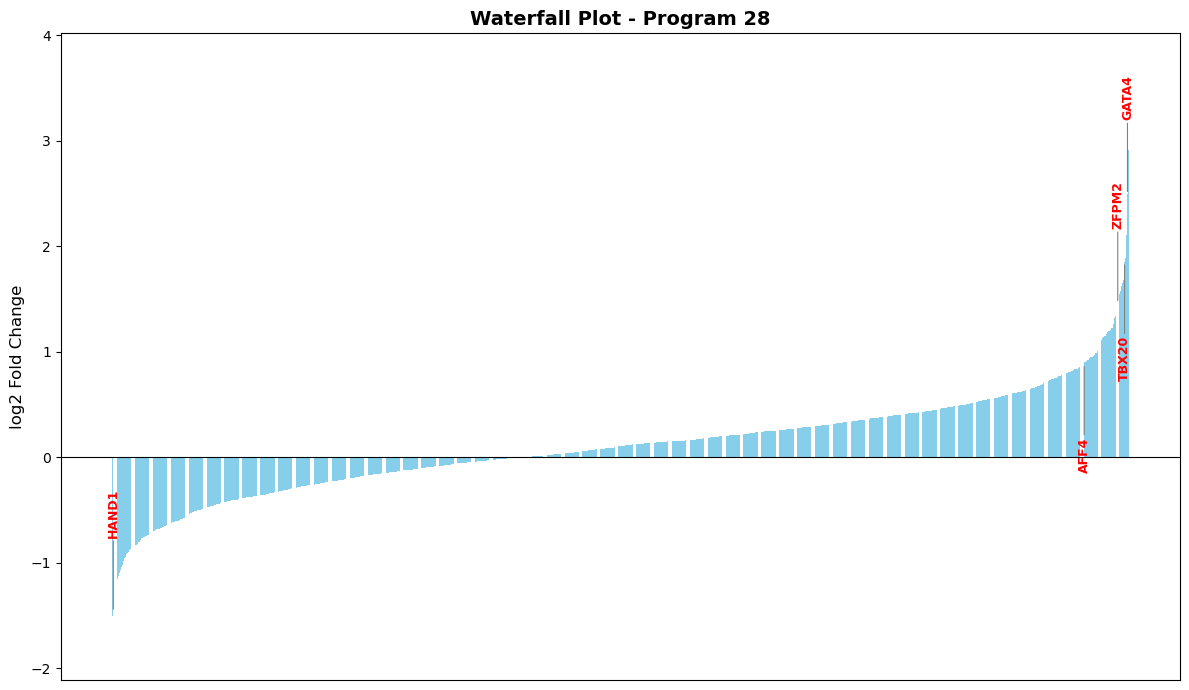

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by log2 Fold Change
df = prog_28_pert_all.sort_values(by='Log2 Fold Change', ascending=True).reset_index(drop=True)

# Genes to label
label_genes = ['HAND1','ZFPM2', 'AFF4','TBX20','GATA4']

# Plot setup
plt.figure(figsize=(12, 7))
bars = plt.bar(range(len(df)), df['Log2 Fold Change'], color='skyblue')

# Hide x-ticks (optional)
plt.xticks([], [])

# Alternate labels top and bottom
direction = 1  # 1 = above, -1 = below

for idx, row in df.iterrows():
    if row['BaseGene'] in label_genes:
        y = row['Log2 Fold Change']
        
        # Placement
        offset = 0.7 * direction  # slightly bigger for space
        va = 'bottom' if direction == 1 else 'top'
        
        # Text
        plt.text(idx,
                 y + offset,
                 row['BaseGene'],
                 ha='center',
                 va=va,
                 rotation=90,
                 fontsize=9,
                 fontweight='bold',
                 color='red')
        
        # Line or arrow
        plt.annotate('',
                     xy=(idx, y),  # start at the bar
                     xytext=(idx, y + offset),  # end at label
                     arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
        
        # Flip direction
        direction *= -1

# Final plot decoration
plt.ylabel('log2 Fold Change', fontsize=12)
plt.title('Waterfall Plot - Program 28', fontsize=14, fontweight='bold')
plt.axhline(0, color='black', linewidth=0.8)  # optional: add a zero-line
plt.tight_layout()
plt.savefig('/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_28_water_fall_plot.pdf', dpi=300)

# Show plot
plt.show()


In [104]:
prog_28_pert = K_250[K_250["Program"]==28]
pd.set_option('display.max_colwidth', None)
prog_28_pert = prog_28_pert.sort_values(by = "Log2 Fold Change",ascending=True)




#prog_28_pert.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program28_TF_full_cellular_matrix_10_25.csv")

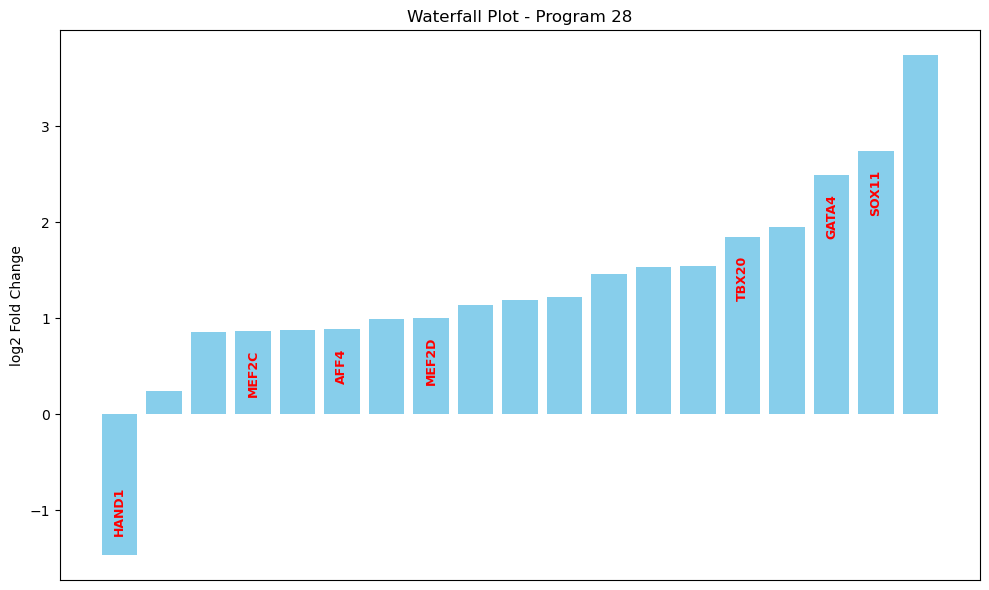

In [144]:
import matplotlib.pyplot as plt

# Sort by log2FC
df = prog_28_pert.sort_values(by='Log2 Fold Change', ascending=True).reset_index(drop=True)

# Genes to label
label_genes = ['HAND1','MEF2C', 'AFF4','TBX20','MEF2D','GATA4','SOX11']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(df)), df['Log2 Fold Change'], color='skyblue')

# Add gene labels on x-axis if needed (or use index numbers)
# plt.xticks(range(len(df)), df['Gene'], rotation=90, fontsize=8)
plt.xticks([], [])

# Loop over sorted DataFrame rows
for i, row in df.iterrows():
    if row['BaseGene'] in label_genes:
        y = row['Log2 Fold Change']
        
        # Flip label placement: bottom for positive, top for negative
        y_offset = -0.2 if y > 0 else 0.2
        va = 'top' if y > 0 else 'bottom'
        
        plt.text(i,
                 y + y_offset,
                 row['BaseGene'],
                 ha='center',
                 va=va,
                 rotation=90,
                 fontsize=9, fontweight='bold', color='red')

plt.ylabel('log2 Fold Change')
plt.title('Waterfall Plot - Program 28')
plt.tight_layout()
plt.savefig('/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_28_water_fall_plot.pdf', dpi=300)


plt.show()


## violin plot

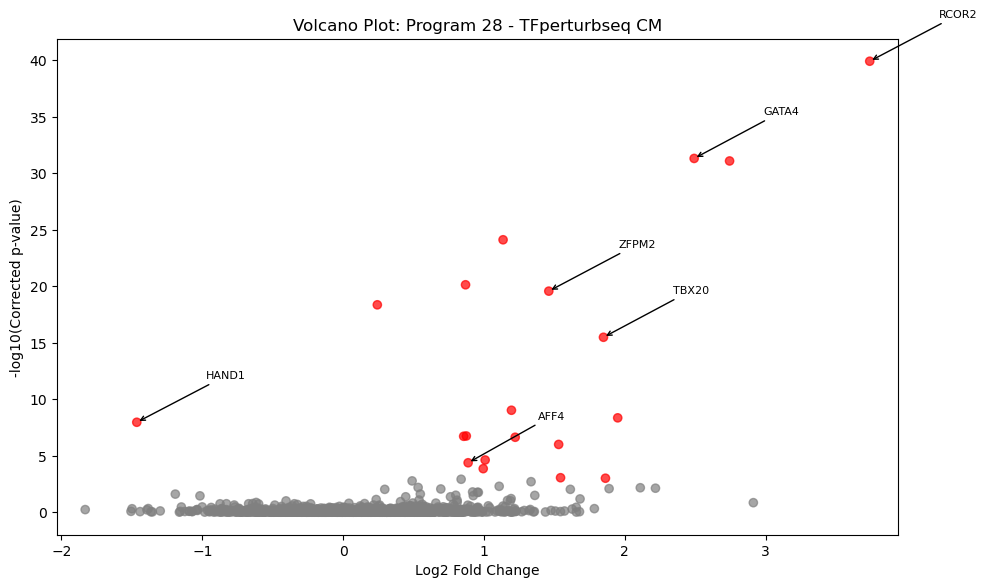

In [35]:
# Drop rows with missing values
df = prog_28_pert_all.dropna(subset=['Log2 Fold Change', 'Corrected p-value (BH)', 'BaseGene']).copy()

# Compute -log10(p-value)
df['-log10(p-value adj)'] = -np.log10(df['Corrected p-value (BH)'])

# Define colors for significant points
colors = np.where(df['Corrected p-value (BH)'] < 0.001, 'red', 'gray')


plt.figure(figsize=(10, 6))
plt.scatter(
    df['Log2 Fold Change'], 
    df['-log10(p-value adj)'], 
    color=colors, 
    alpha=0.7
)


genes_to_label =  ['HAND1','ZFPM2', 'AFF4','TBX20','GATA4','RCOR2']

# Label selected genes with arrows and offset text
for _, row in df[df['BaseGene'].isin(genes_to_label)].iterrows():
    plt.annotate(
        row['BaseGene'],
        xy=(row['Log2 Fold Change'], row['-log10(p-value adj)']),
        xytext=(50, 30),  # offset label position in points (x,y)
        textcoords='offset points',
        ha='left',
        va='bottom',
        fontsize=8,
        arrowprops=dict(arrowstyle='->', color='black', lw=1)
    )

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Corrected p-value)')
plt.title('Volcano Plot: Program 28 - TFperturbseq CM')

plt.xlim(df['Log2 Fold Change'].min() - 0.2, df['Log2 Fold Change'].max() + 0.2)

plt.tight_layout()
plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full/TF_perturb_full/TF_full_CM_program28_violinplot.pdf")
plt.show()
    

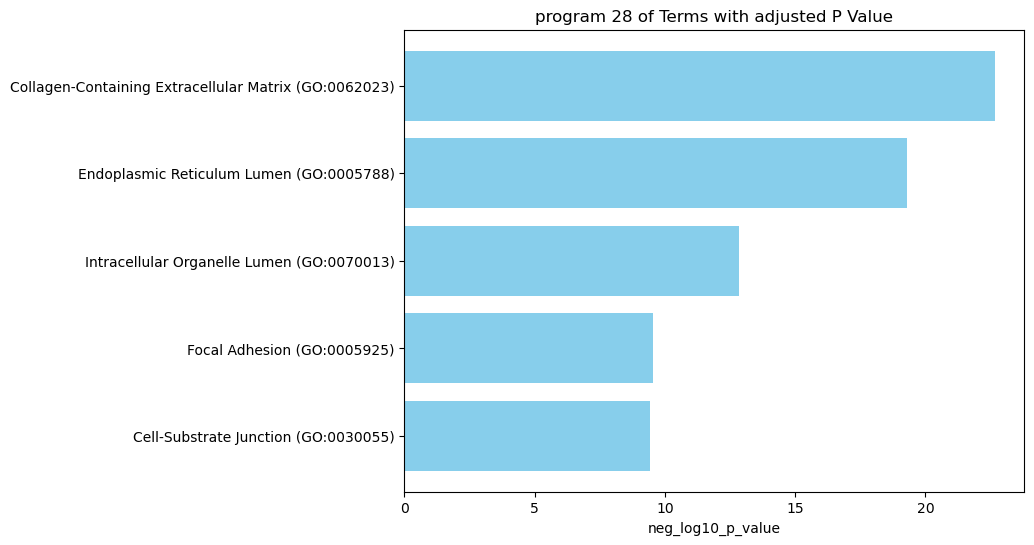

In [53]:
GO_col28 = GO_250[GO_250["Source"]==28]
GO_col28 = GO_col28[GO_col28["Adjusted P-value"]<0.05]
GO_col28 = GO_col28.sort_values(by = "neg_log10_p_value",ascending=False)
GO_col28 = GO_col28.iloc[:5,:]






plt.figure(figsize=(8, 6))
plt.barh(GO_col28['Term'], GO_col28['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 28 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()